Implementing a basic graph convolution

In [ ]:
pip install networkx

In [ ]:
import numpy as np
import networkx as nx

In [ ]:
G = nx.Graph()

blue, orange, green = '#1f77b4', '#ff7f0e', '#eca02c'

G.add_nodes_from([
    (1, {"color": "blue"}),
    (2, {"color": "orange"}),
    (3, {"color": "blue"}),
    (4, {"color": "green"})
])

G.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

In [ ]:
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [ ]:
def build_graph_color_label_representation(G, mapping_dict):
  one_hot_idxs = np.array([mapping_dict[v] for v in
              nx.get_node_attributes(G, 'color').values()])
  one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
  one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
  return one_hot_encoding

In [ ]:
X = build_graph_color_label_representation(G, {'blue': 0, 'orange': 1, 'green': 2})
print(X)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


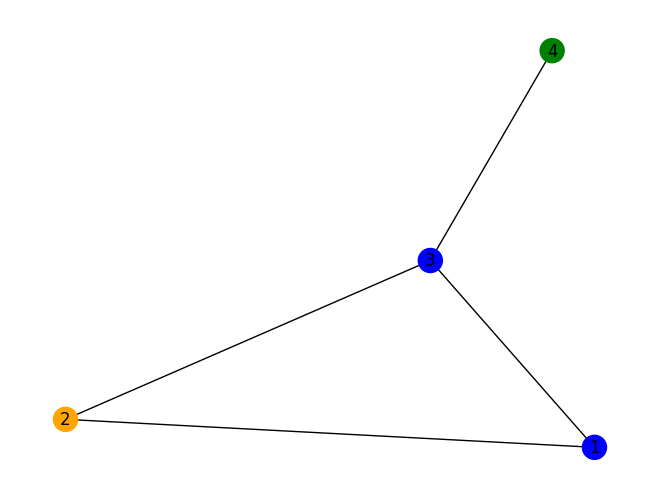

In [ ]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels = True, node_color=color_map)

Implementing a GNN in PyTorch from scratch

In [ ]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import math
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
class NodeNetowrk(torch.nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.conv_1 = BasicGraphConvolutionLayer(
        input_features, 32
    )
    self.conv_2 = BasicGraphConvolutionLayer(32, 32)
    self.fc_1 = torch.nn.Linear(32, 16)
    self.out_layer = torch.nn.Linear(16, 2)

  def forward(self, X, A, batch_mat):
    #Perform two graph convolutions:
    x = F.relu(self.conv_1(X, A))
    x = F.relu(self.conv_2(x, A))

    #Pool al the node embeddings:
    output = global_sum_pool(x, batch_mat)

    # Run the pooled embeddings through two FCL:
    output = self.fc_1(output)
    output = self.out_layer(output)

    # Output a class-membership probability:
    return F.softmax(output, dim=1)

In [ ]:
class BasicGraphConvolutionLayer(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    #Random initialization of the weights matrix: (in x out)
    self.W2 = Parameter(torch.rand(in_channels, out_channels, dtype=torch.float32))
    self.W1 = Parameter(torch.rand(in_channels, out_channels, dtype=torch.float32))

    #Zero initialization of the bias matrix: (1 x out)
    self.bias = Parameter(torch.zeros(out_channels, dtype=torch.float32))

  def forward(self, X, A):
    potential_msgs = torch.mm(X, self.W2)
    propagated_msgs = torch.mm(A, potential_msgs)
    root_update = torch.mm(X, self.W1)
    output = propagated_msgs + root_update + self.bias
    return output

In [ ]:
def global_sum_pool(X, batch_mat):
  # 1-dimensional tensor (single graph):
  if batch_mat is None or batch_mat.dim() == 1:
    return torch.sum(X, dim=0).unsqueeze(0)
  # >1-dimensional tensor (batch of graphs):
  else:
    return torch.mm(batch_mat, X)

In [ ]:
def get_batch_tensor(graph_sizes):
  # To work with several graphs simultaneously.

  # Store the starting and ending index of each graph.
  starts = [sum(graph_sizes[:i]) for i in range(len(graph_sizes))]
  stops = [starts[i] + graph_sizes[i] for i in range(len(graph_sizes))]
  tot_len = sum(graph_sizes) # Number of nodes
  batch_size = len(graph_sizes) # Number of graphs
  batch_mat = torch.zeros([batch_size, tot_len]).float()
  for i, starts_and_stops in enumerate(zip(starts, stops)):
    start = starts_and_stops[0]
    stop = starts_and_stops[1]
    # For every graph, if the node belongs to the graph batch_mat=1
    batch_mat[i, start:stop] = 1
  return batch_mat

In [ ]:
def collate_graphs(batch):
  # Just to process a batch of GNNs. Unified representation.
  adj_mats = [graph['A'] for graph in batch]
  sizes = [A.size(0) for A in adj_mats]
  tot_size = sum(sizes)
  batch_mat = get_batch_tensor(sizes)
  feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)
  labels = torch.tensor([graph['y'] for graph in batch])
  batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
  accum = 0
  for adj in adj_mats:
    g_size = adj.shape[0]
    batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
    accum += g_size
  return {'A': batch_adj, 'X': feat_mats, 'y': labels, 'batch_mat': batch_mat}

In [ ]:
def get_graph_dict(G, mapping_dict):
  A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
  X = torch.from_numpy(build_graph_color_label_representation(G, mapping_dict))
  y = torch.tensor([[1,0]]).float()
  return {'A': A, 'X': X, 'y': y, 'batch': None}

In [ ]:
blue, orange, green = '#1f77b4', '#ff7f0e', '#eca02c'
mapping_dict = {'green': 0, 'blue': 1, 'orange': 2}

Just some matrix

In [ ]:
G1 = nx.Graph()
G1.add_nodes_from([
    (1, {"color": "blue"}),
    (2, {"color": "orange"}),
    (3, {"color": "blue"}),
    (4, {"color": "green"})
])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

In [ ]:
G2 = nx.Graph()
G2.add_nodes_from([
    (1, {"color": "green"}),
    (2, {"color": "green"}),
    (3, {"color": "orange"}),
    (4, {"color": "orange"}),
    (5, {"color": "blue"})
])
G2.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1)])

In [ ]:
G3 = nx.Graph()
G3.add_nodes_from([
    (1, {"color": "orange"}),
    (2, {"color": "orange"}),
    (3, {"color": "green"}),
    (4, {"color": "green"}),
    (5, {"color": "blue"}),
    (6, {"color": "orange"})
])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])

In [ ]:
G4 = nx.Graph()
G4.add_nodes_from([
    (1, {"color": "blue"}),
    (2, {"color": "blue"}),
    (3, {"color": "green"})
])
G4.add_edges_from([(1, 2), (2, 3)])

In [ ]:
graph_list= [get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]]

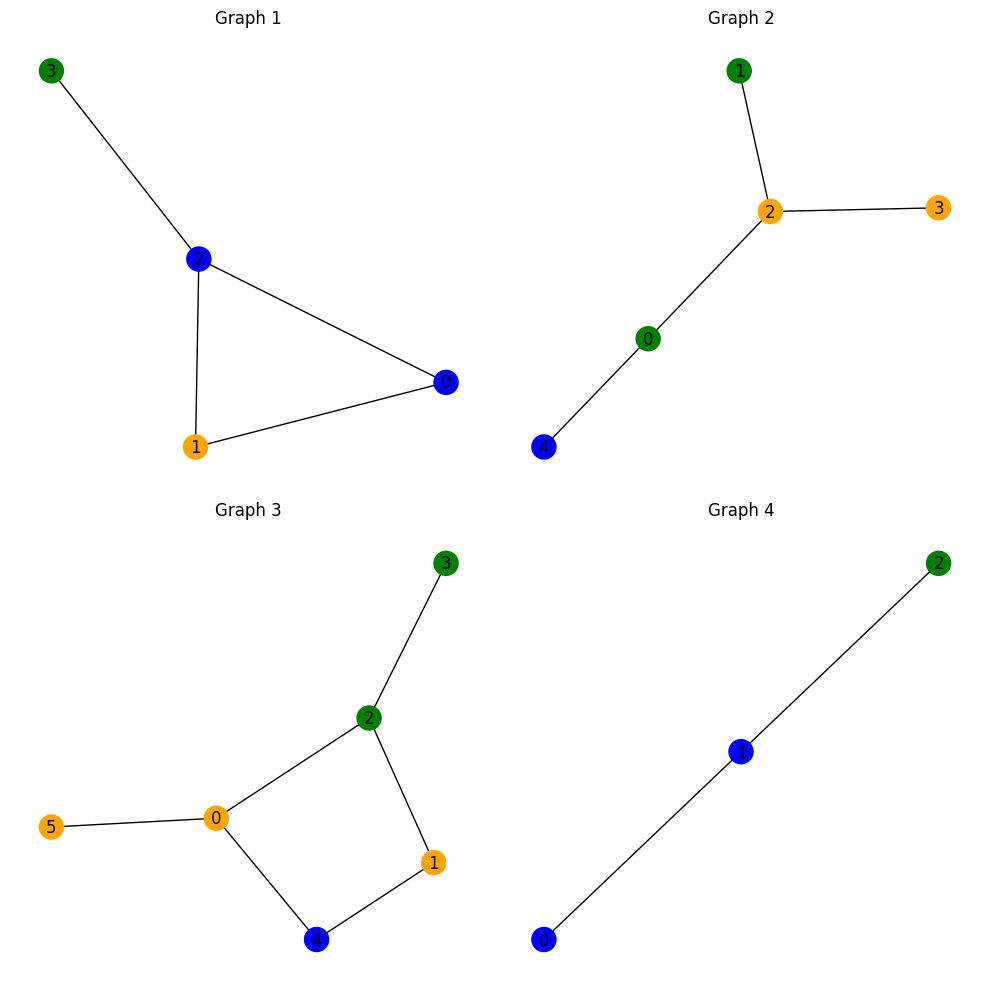

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(graph_list):
        graph_data = graph_list[i]
        G = nx.from_numpy_array(graph_data['A'].numpy())
        node_colors = [list(mapping_dict.keys())[list(mapping_dict.values()).index(int(x))] for x in graph_data['X'].argmax(dim=1).numpy()]

        nx.draw(G, with_labels=True, node_color=node_colors, ax=ax)
        ax.set_title(f'Graph {i+1}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
